In [1]:
import os
import numpy as np
import torch
import random
import parmed
import nglview as ng
import MDAnalysis as md
from MDAnalysis.analysis import dihedrals
import matplotlib.pyplot as plt

import mymd

In [2]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
data_path = '../../data/md_from_scratch/'
csv_path = '../tmp/'
dcd_path = '../tmp/'
dt_fs = 2

# ala15 in openmm
old_pdb_file = os.path.join(data_path, 'ala15.pdb')
pdb_file = os.path.join(data_path, 'ala15_new.pdb')
psf_file = os.path.join(data_path, 'ala15.psf')
prmtop_file = os.path.join(data_path, 'ala15.prmtop')
coor_file = None
xsc_file = None
cutoff = None
T = 300.15
dcd_interval = 100
steps = 20000

# structure: prod_alanine_dipeptide_amber
# prmtop_file = os.path.join(data_path, 'structure.prmtop')
# coor_file = os.path.join(data_path, 'input.coor')
# xsc_file = os.path.join(data_path, 'input.xsc')
# psf_file = None
# pdb_file = None
# cutoff = 9
# T = 300
# dcd_interval = 10
# steps = 500

In [ ]:
# for ala15 in openmm
# mymd.gen_files_from_pdb(old_pdb_file=old_pdb_file,
#                         psf_file=psf_file,
#                         prmtop_file=prmtop_file,
#                         new_pdb_file=pdb_file)

In [ ]:
mol = mymd.get_molecule(prmtop_file=prmtop_file, pdb_file=pdb_file, coor_file=coor_file, xsc_file=xsc_file)
print('---coords---')
print(mol.coords[:2])
print('-----box-----')
print(mol.box)
print('---charge---')
print(mol.charge[:3])
print('---masses---')
print(mol.masses[:3])
print('----bonds----')
print(mol.bonds[:4])
print('---bonds.shape---')
print(mol.bonds.shape)

In [ ]:
try:
    ff = mymd.PrmtopMolForceField(mol, prmtop_file, allow_unequal_duplicates=False)
except:
    print('False causes error, use True.')
    ff = mymd.PrmtopMolForceField(mol, prmtop_file, allow_unequal_duplicates=True)

print(ff.mol.atomtype[:10])
print(ff.mol.charge[:10])  # same atomtype can have different charge ('C1') in ala15 in openmm
print(set(ff.mol.atomtype))
print(set(ff.params.atom_types))

In [ ]:
system = mymd.System(mol, ff, cutoff=cutoff)
print(system.bond_params[:5])
print(system.improper_params[0]['params'][:5])
print(system.uni_atom_types == np.unique(mol.atomtype))
print(system.uni_atom_types[system.mapped_atom_types[:6]] == mol.atomtype[:6])
print(system.box, mol.box)
print(system.cutoff)
print(system.external)
print(np.array(system.get_exclusions(types=['bonds']))[:3])
print(np.all(np.vstack((np.array(system.bonds), np.array(system.angles[:, [0, 2]]))) == np.array(system.get_exclusions(types=['bonds', 'angles']))))

In [ ]:
integrator = mymd.VelocityVerletIntegrator(dt_fs)
print(integrator.dt, integrator.dt_fs)

In [ ]:
simulation = mymd.Simulation(mol, system, integrator, 'cpu', torch.float)
simulation.set_positions(mol.coords)
simulation.set_velocities_to_temperature(T=T)
simulation.update_potentials_and_forces()

csv_reporter = mymd.CSVReporter(csv_path, 1)
simulation.add_reporter(csv_reporter)

print(torch.abs(simulation.vel).mean())
print(simulation.forces.shape)
print(simulation.forces[:5])
print(simulation.forces[-3:])
print(simulation.potentials)
print(simulation.potentials_sum)

In [ ]:
print(simulation.pos[:5])
simulation.minimize_energy(100)
print(simulation.pos[:5])
print(simulation.forces[:5])
print(simulation.potentials)
print(simulation.potentials_sum)

In [ ]:
simulation.step(steps, dcd_path, dcd_interval)

In [4]:
if psf_file is not None:
    u = md.Universe(psf_file, os.path.join(dcd_path, 'traj.dcd'))
else:
    u = md.Universe(prmtop_file, os.path.join(dcd_path, 'traj.dcd'))

ng.show_mdanalysis(u, gui=True)

2023-05-10 17:12:48,751 - MDAnalysis.topology.PSF - WARNING - Guessing that this is actually a NAMD-type PSF file... continuing with fingers crossed!


NGLWidget(max_frame=200)

/Users/jerrykwan/anaconda3/envs/temp/lib/python3.9/site-packages/MDAnalysis/analysis/dihedrals.py:422: UserWarning: Cannot determine phi and psi angles for the first or last residues
  warnings.warn("Cannot determine phi and psi angles for the first "
2023-05-10 17:12:50,975 - MDAnalysis.analysis.base - INFO - Choosing frames to analyze
2023-05-10 17:12:50,976 - MDAnalysis.analysis.base - INFO - Starting preparation
2023-05-10 17:12:50,993 - MDAnalysis.analysis.base - INFO - Finishing up
2023-05-10 17:12:51,002 - MDAnalysis.analysis.base - INFO - Choosing frames to analyze
2023-05-10 17:12:51,004 - MDAnalysis.analysis.base - INFO - Starting preparation
2023-05-10 17:12:51,011 - MDAnalysis.analysis.base - INFO - Finishing up
2023-05-10 17:12:51,020 - MDAnalysis.analysis.base - INFO - Choosing frames to analyze
2023-05-10 17:12:51,026 - MDAnalysis.analysis.base - INFO - Starting preparation
2023-05-10 17:12:51,040 - MDAnalysis.analysis.base - INFO - Finishing up


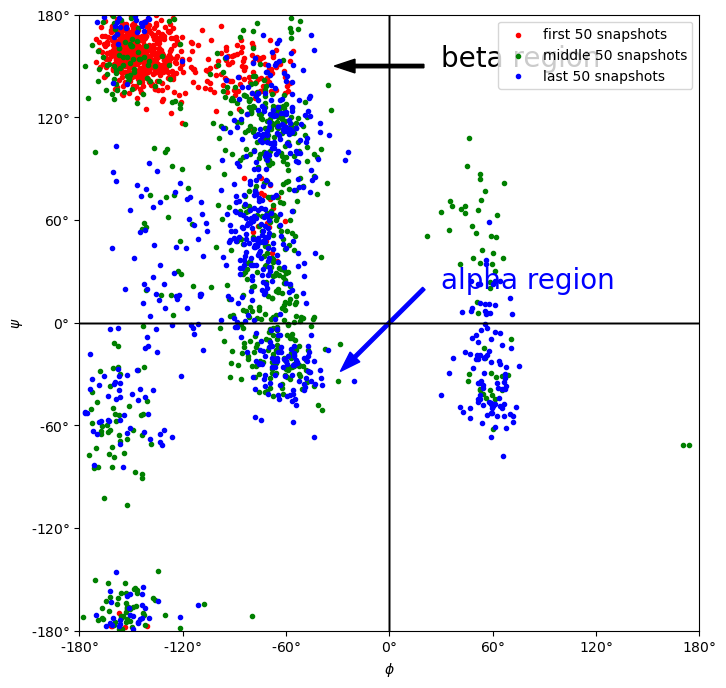

In [5]:
if psf_file is not None:
    # ala15
    ram1 = dihedrals.Ramachandran(u).run(0, 50) 
    ram_mid = dihedrals.Ramachandran(u).run(100, 150)
    ram2 = dihedrals.Ramachandran(u).run(150, 200)  # maybe not include the last snapshot

    ## ramachandran plot
    fig, ax = plt.subplots(figsize=(8,8))
    ram1.plot(ax=ax, color='r', marker='.', label='first 50 snapshots')
    ram_mid.plot(ax=ax, color='g', marker='.', label='middle 50 snapshots')
    ram2.plot(ax=ax, color='b', marker='.', label='last 50 snapshots')
    ax.arrow(20, 20, -40, -40, width=2, head_width=8, head_length=12, fc='b', ec='b')
    ax.text(30, 20, 'alpha region', color='blue', fontsize=20)
    ax.arrow(20, 150, -40, 0, width=2, head_width=8, head_length=12, fc='k', ec='k')
    ax.text(30, 150, 'beta region', fontsize=20)
    plt.legend()
    plt.show()